In [119]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, jaccard_score
from prettytable import PrettyTable
from PIL import Image
import sys
import os
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import pickle

In [120]:
# reading the dataset
dir_names = ['./dataset/A/', './dataset/B/', './dataset/label/']

A_images = []
B_images = []
true_delta = []

# reading A images
for fileName in os.listdir(dir_names[0]):
    # read the image, convert it into grey scale and then store it into a numpy array
    image =  np.array(Image.open(os.path.join(dir_names[0], fileName)))    
    # add the image of the list
    A_images.append(image)

A_images = np.array(A_images)

# reading B images
for fileName in os.listdir(dir_names[1]):
    # read the image, convert it into grey scale and then store it into a numpy array
    image =  np.array(Image.open(os.path.join(dir_names[1], fileName)))
    # add the image of the list
    B_images.append(image)

B_images = np.array(B_images)

# reading truth images
for fileName in os.listdir(dir_names[2]):
    # read the image, convert it into grey scale and then store it into a numpy array
    image =  np.array(Image.open(os.path.join(dir_names[2], fileName)))
    # add the image of the list
    true_delta.append(image)

true_delta = np.array(true_delta)

In [121]:
# this function calculates jaccard score using every predicted image and its corresponding ground truth then average all the scores
def score(truth_ground, predicted):

    # convert images into binary
    truth_ground[truth_ground != 0] = 1
    predicted[predicted != 0] = 1
    scores = 0
    
    for i in range(0, len(predicted)):
        scores += jaccard_score(truth_ground[i], predicted[i], average='micro')

    return scores / len(predicted)

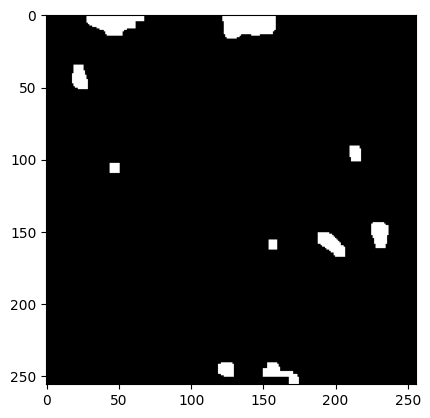

(1, 256, 256)
0.12974839664528862


In [193]:
# classical method: PCA with K-means (unsupervised method that has no training)
class PCA_Kmean:

    # initialization function, h is a parameter that will determine the size of blocks of image
    def __init__(self, h=7):
        self.h = h 

    # the training function has no meaning as this method is unsupervised method so there is no point of having true labels and train the model using these labels

    # this function takes both A and B images and apply the algorithm on both of them and output the predicted ground truth
    def predict(self, A_test, B_test):
        
        # the array in which we will store the result difference images
        self.result_images = []

        # loop over all the images
        for i in range(0, len(A_test) // 9): 

            # print(f"processing image number {i}", end = "\r")

            # apply gaussian blur to the image
            blk = int(self.h // 2)
            a_test_blur = cv2.GaussianBlur(A_test[i], (blk, blk), 0)
            b_test_blur = cv2.GaussianBlur(B_test[i], (blk, blk), 0)

            # first calculate the absolute difference between A and B images
            difference_image = np.abs(a_test_blur - b_test_blur)

            # resize the image so that it can be divided into integer number of 'self.h' non-overlapping blocks
            resized_difference = cv2.resize(difference_image, dsize=(np.array((A_test[i].shape[0], A_test[i].shape[1])) // self.h) * self.h)

            # loop over the channels of the image
            images = []
            for channel in range(0, 3):

                # find the vector set, we divide the difference image into non-overlapping blocks and then each block is flattened to represent a vector then all of the vectors are subtracted from their mean vector
                vectors = []
                for j in range(0, resized_difference.shape[0] // self.h):
                    for k in range(0, resized_difference.shape[1] // self.h):
                        vectors.append(resized_difference[j:j+self.h, k:k+self.h, channel].ravel())
                vectors = np.array(vectors)
                mean_vector = np.mean(vectors, axis=0)
                delta_vectors = vectors - mean_vector


                # apply PCA on the delta vectors to get the PCA components
                pca = PCA()
                pca.fit(delta_vectors)
                
                # project each point into the new vector space where each point will be represented by using an overlapping blocks around each point then flatten them
                point_vector = []
                pad = self.h // 2            
                for j in range(pad, resized_difference.shape[0] - pad):
                    for k in range(pad, resized_difference.shape[1] - pad):
                        point_vector.append(resized_difference[j-pad:j+pad+1, k-pad:k+pad+1, channel].ravel())
                point_vector = np.array(point_vector) - mean_vector
                projected_points = np.dot(point_vector, pca.components_)

                # apply Kmeans clustering on the projected points where the cluster that has low number of points and average high means is considered the cluster that changed values
                kmeans = KMeans(n_clusters=2)
                kmeans.fit(projected_points)
                predicted_labels = kmeans.predict(projected_points).astype(np.uint8)
                least_common_idx  = Counter(predicted_labels).most_common()[-1][0]
                predicted_labels_map = np.reshape(predicted_labels, newshape=(np.array(A_test[i].shape) // self.h) * self.h - 2 * pad)
                predicted_labels_map = cv2.resize(predicted_labels_map, dsize=(np.array((A_test[i].shape[0], A_test[i].shape[1]))))

                predicted_labels_map[predicted_labels_map == least_common_idx] = 255
                predicted_labels_map[predicted_labels_map != 255] = 0

                # perform erosion and  to clean the image
                kernel = np.ones((self.h, self.h), np.uint8) 
                opened_image = cv2.morphologyEx(predicted_labels_map, cv2.MORPH_OPEN, kernel, iterations=1) 
                closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel, iterations=1) 

                images.append(closed_image)

            # apply intersection between the 3 bands to get the pixels that has changed all of its R, G, B values
            intersection = cv2.bitwise_and(cv2.bitwise_and(images[0], images[1]), images[2])

            # plt.imshow(intersection, cmap='grey', vmin=0, vmax=255)
            # plt.show()
            # plt.imshow(images[0], cmap='grey', vmin=0, vmax=255)
            # plt.show()
            # plt.imshow(images[1], cmap='grey', vmin=0, vmax=255)
            # plt.show()            
            # plt.imshow(images[2], cmap='grey', vmin=0, vmax=255)
            # plt.show()


            # find the contours in the intersection image
            contours, hierarchy = cv2.findContours(intersection, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

            # loop over all the contours
            rectangles = []
            for cnt in contours:

                # approximate every contour to be a polygon
                poly = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)

                # find the minimum area of bounding rotated rectangle
                rotated_rect = cv2.minAreaRect(poly)
                area = rotated_rect[1][0] * rotated_rect[1][1]

                # check if the minimum area of rotated rectangle is nearly equal to the area of that polygon
                if (area != 0) and abs(1 - (cv2.contourArea(poly) / area)) < 0.9: 
                    rectangles.append(poly)


            self.result_images.append(intersection)
            return np.array(self.result_images)
            break






            

            for rect in rectangles:
              cv2.drawContours(b_test_blur, [rect], -1, (0,0,0), thickness=cv2.FILLED)

            # cv2.drawContours(b_test_blur, contours, -1, (0,0,0), 1)

            plt.imshow(b_test_blur, cmap='gray', vmin=0, vmax=255)
            plt.show()

            break

            result_images.append(dilated_image)


        return np.array(result_images)


    

pca_kmeans = PCA_Kmean()
# A_test = np.array([0])
# B_test = np.array([0])
predicted_difference = pca_kmeans.predict(A_images, B_images)
print(predicted_difference.shape)

# print(np.where(true_delta[0] == 1))
print(score(true_delta, predicted_difference))
# print(predicted_difference.shape)
# print(true_delta, predicted_difference)

In [16]:
# Set random seed for reproducibility
np.random.seed(27)  

# select test indices where the test data size will be 20% of the whole data
test_indices = np.random.choice(np.arange(len(true_delta)), size=0.2*(len(true_delta)), replace=False)

# split data into training and testing data
true_delta_test = true_delta[test_indices]
A_images_test = A_images[test_indices]
B_images_test = B_images[test_indices]

true_delta_train = np.delete(true_delta, test_indices, 0)
A_images_train = np.delete(A_images, test_indices, 0)
B_images_train = np.delete(B_images, test_indices, 0)


4868
4868
4868


In [ ]:
class UNET:

    def __init__(self) -> None:
        pass

    def train(self, a_image_train, b_image_train, true_delta_train):
        pass

    def predict(self, a_image_test, b_image_test):
        pass


# create and save UNET model
unet = UNET()
unet.train(A_images_train, B_images_train, true_delta_train)
pickle.dump(unet, open('unet_model', 'wb'))


In [ ]:
def save_visualize(A, B, true, pca_kmeans, UNET):
    
    for i in range(0, len(A)):
        # concatenate images and store them to the output
        # output_image = np.zeros((A_images[i].shape[0], 4*A_images[i].shape[1]), dtype=np.uint8) 
        # output_image[:, A_images[i].shape[0] * 0:A_images[i].shape[0] * 1] = A_images[i]
        # output_image[:, A_images[i].shape[0] * 1:A_images[i].shape[0] * 2] = B_images[i]
        # output_image[:, A_images[i].shape[0] * 2:A_images[i].shape[0] * 3] = true_delta[i]
        # output_image[:, A_images[i].shape[0] * 3:A_images[i].shape[0] * 4] = dilated_image
        # cv2.imwrite(f'./output/{i}.PNG', output_image)
        pass

In [ ]:
unet = pickle.load(open('unet_model', 'rb'))
predicted_mask = unet.predict(A_images_test, B_images_test)
print(score(true_delta_test, predicted_mask))